In [1]:
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from src.datasets import Cars, Puzzles, Synthetic
from src.models import MLP, SBR, SBRBatchGenerator, UnivariateSBR, hard_tanh

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
sns.set_style('whitegrid')
sns.set_context('notebook')

OUTPUT_ACT = None
H_UNITS = [16] * 4
OPTIMIZER = 'adam'
LOSS = 'mse'
EPOCHS = 1000

synth = Synthetic()
cars = Cars(filepath='../res/cars.csv')
puzzles = Puzzles(filepath='../res/puzzles.csv')


def get_callbacks(monitor='val_loss', patience=50):
    return [EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)]

# Synthetic Dataset

150 train samples, 50 validation samples, 500 test samples


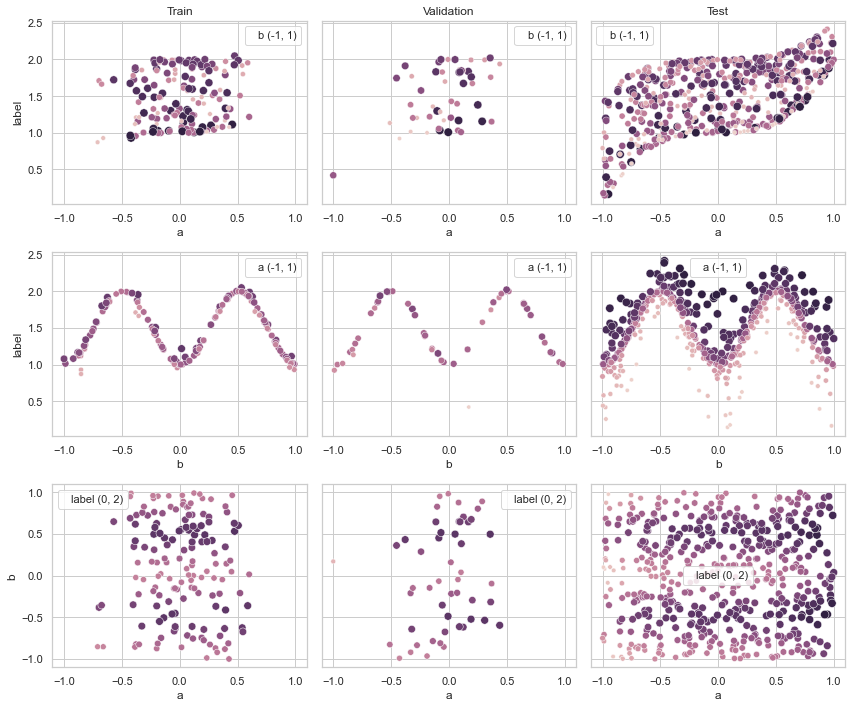

In [2]:
data, scalers = synth.load_data()
x_train, y_train = data['train']
x_val, y_val = data['validation']

synth.plot_data(**data)

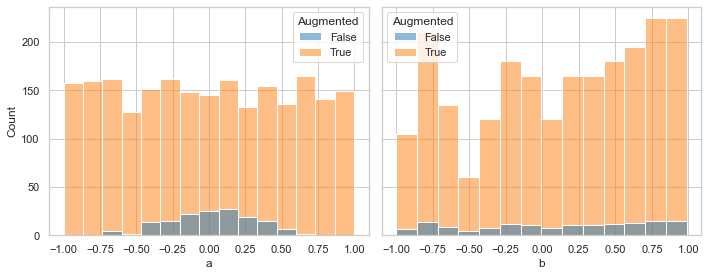

In [3]:
(x_aug, y_aug), aug_scalers = synth.get_augmented_data(x_train, y_train, num_augmented=15)
synth.plot_augmented(x_aug, y_aug)

## MLP

0.03996 (avg. violation), 0.2886 (pct. violation)
0.9967 (train r2), 0.9009 (validation r2), 0.6434 (test r2)


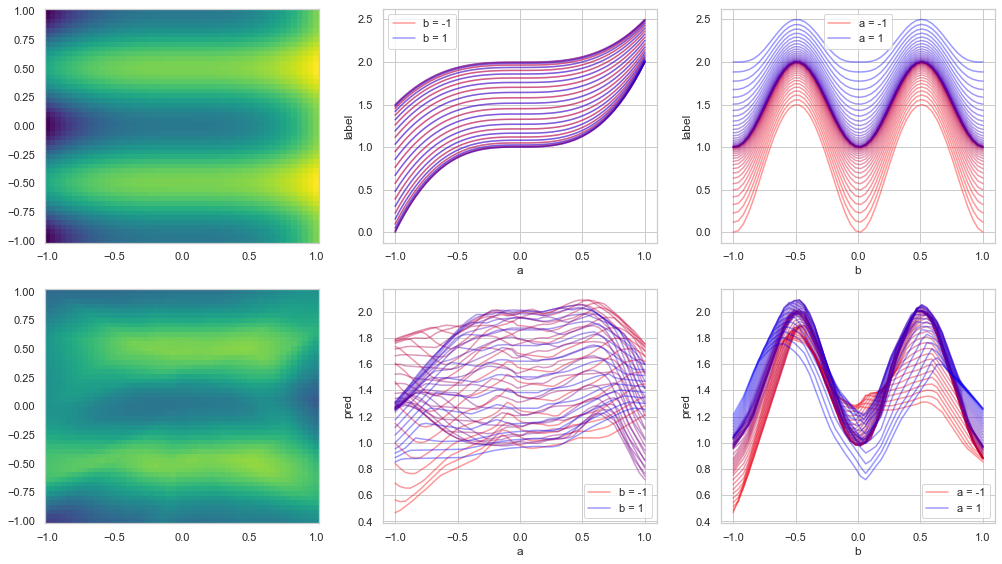

In [4]:
mlp = MLP(output_act=OUTPUT_ACT, h_units=H_UNITS, scalers=scalers)
mlp.compile(optimizer=OPTIMIZER, loss=LOSS)

mlp.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=get_callbacks(), verbose=0)
synth.evaluation_summary(mlp, **data)

## SBR

In [5]:
sbr_batches = SBRBatchGenerator(x_aug, y_aug['label'], y_aug['ground_index'], y_aug['monotonicity'], 4)
sbr_batches.batches[0].head(16)

,a,b,label,monotonicity
0,0.454177,0.963885,1.112615,0.0
1,-0.245073,0.963885,NaN,-1.0
2,0.416999,0.963885,NaN,-1.0
3,-0.538156,0.963885,NaN,-1.0
4,-0.712349,0.963885,NaN,-1.0
5,0.497800,0.963885,NaN,1.0
6,0.337456,0.963885,NaN,-1.0
7,-0.141259,0.963885,NaN,-1.0
8,-0.726465,0.963885,NaN,-1.0
9,0.327367,0.963885,NaN,-1.0


0.0001428 (avg. violation), 0.00949 (pct. violation)
0.993 (train r2), 0.9721 (validation r2), 0.9138 (test r2)


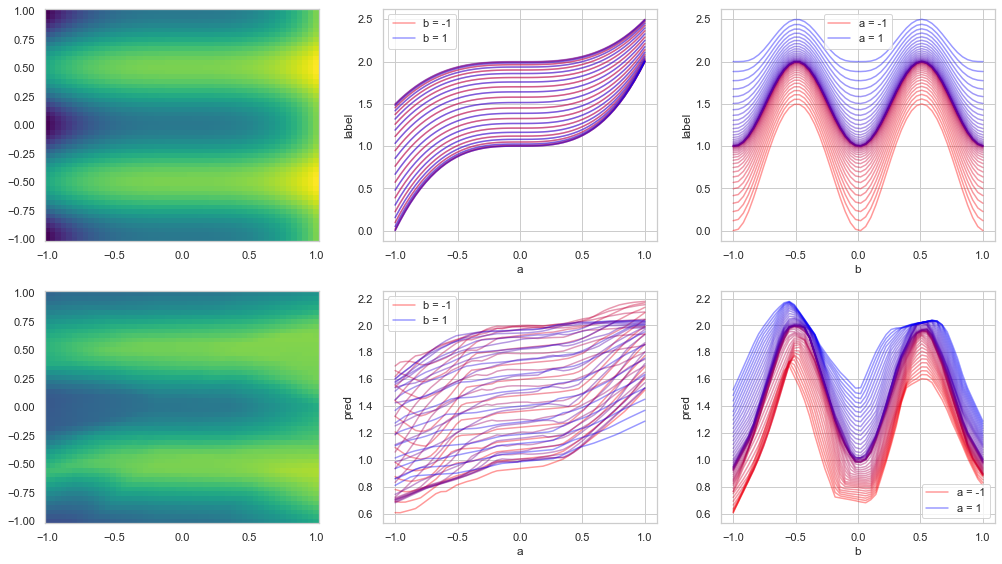

In [6]:
sbr_none = SBR(output_act=OUTPUT_ACT, h_units=H_UNITS, scalers=aug_scalers)
sbr_none.compile(optimizer=OPTIMIZER, loss=LOSS)

sbr_none.fit(sbr_batches, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=get_callbacks(), verbose=0)
synth.evaluation_summary(sbr_none, **data)

## SBR Tanh

0.01207 (avg. violation), 0.1702 (pct. violation)
0.8579 (train r2), 0.8929 (validation r2), 0.7038 (test r2)


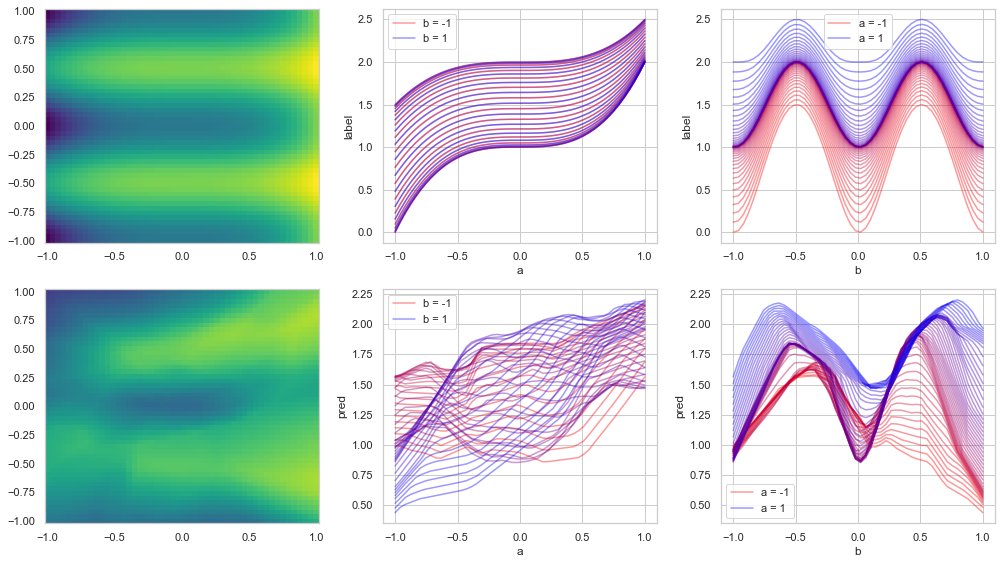

In [7]:
sbr_tanh = SBR(output_act=OUTPUT_ACT, h_units=H_UNITS, regularizer_act=hard_tanh, scalers=aug_scalers)
sbr_tanh.compile(optimizer=OPTIMIZER, loss=LOSS)

sbr_tanh.fit(sbr_batches, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=get_callbacks(), verbose=0)
synth.evaluation_summary(sbr_tanh, **data)

# Cars Dataset

99 train samples, 25 validation samples, 31 test samples


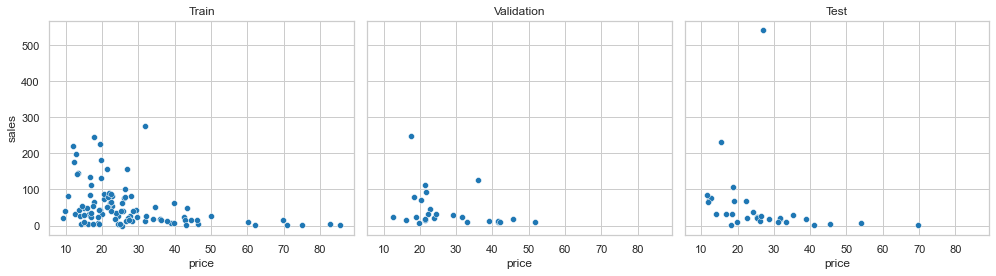

In [8]:
data, scalers = cars.load_data()
x_train, y_train = data['train']
x_val, y_val = data['validation']

cars.plot_data(**data)

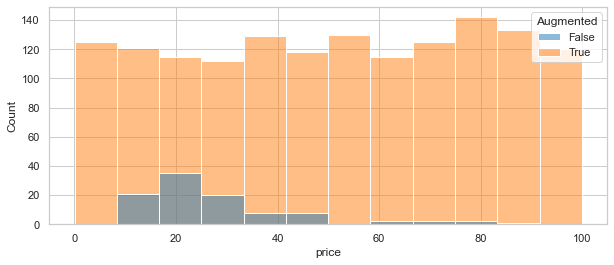

In [9]:
(x_aug, y_aug), aug_scalers = cars.get_augmented_data(x_train, y_train, num_augmented=15)
cars.plot_augmented(x_aug, y_aug)

## MLP

0.00142 (avg. violation), 0.001909 (pct. violation)
0.1272 (train r2), 0.09807 (validation r2), 0.03688 (test r2)


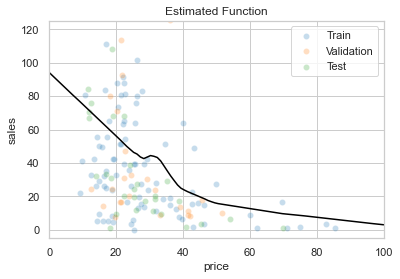

In [10]:
mlp = MLP(output_act=OUTPUT_ACT, h_units=H_UNITS, scalers=scalers)
mlp.compile(optimizer=OPTIMIZER, loss=LOSS)

mlp.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=get_callbacks(), verbose=0)
cars.evaluation_summary(mlp, **data)

## SBR

In [11]:
sbr_batches = SBRBatchGenerator(x_aug, y_aug['sales'], y_aug['ground_index'], y_aug['monotonicity'], 4)
sbr_batches.batches[0].head(16)

,price,label,monotonicity
0,26.000000,76.028999,0.0
1,14.900000,9.761000,0.0
2,0.191736,NaN,1.0
3,88.999557,NaN,-1.0
4,33.473057,NaN,1.0
5,61.657356,NaN,-1.0
6,93.576080,NaN,-1.0
7,6.159854,NaN,1.0
8,54.525345,NaN,-1.0
9,22.221748,NaN,1.0


0.001861 (avg. violation), 0.002959 (pct. violation)
0.1246 (train r2), 0.1016 (validation r2), 0.04516 (test r2)


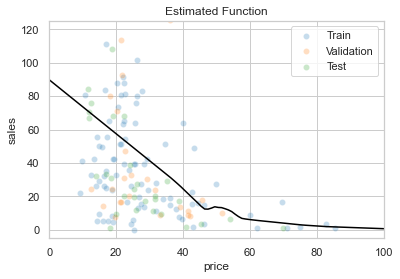

In [12]:
sbr_std = SBR(output_act=OUTPUT_ACT, h_units=H_UNITS, scalers=aug_scalers)
sbr_std.compile(optimizer=OPTIMIZER, loss=LOSS)

sbr_std.fit(sbr_batches, validation_data=(x_val, y_val), epochs=EPOCHS, callbacks=get_callbacks(), verbose=0)
cars.evaluation_summary(sbr_std, **data)

## Univariate SBR

1.465e-05 (avg. violation), 0.0002616 (pct. violation)
0.1388 (train r2), 0.09838 (validation r2), 0.04257 (test r2)


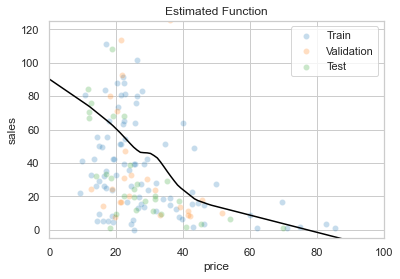

In [13]:
sbr_uni = UnivariateSBR(output_act=OUTPUT_ACT, h_units=H_UNITS, direction=-1, scalers=scalers, input_dim=1)
sbr_uni.compile(optimizer=OPTIMIZER, loss=LOSS)

sbr_uni.fit(x_aug, y_aug['sales'], epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=get_callbacks(), verbose=0)
cars.evaluation_summary(sbr_uni, **data)

# Puzzles Dataset

155 train samples, 168 validation samples, 199 test samples


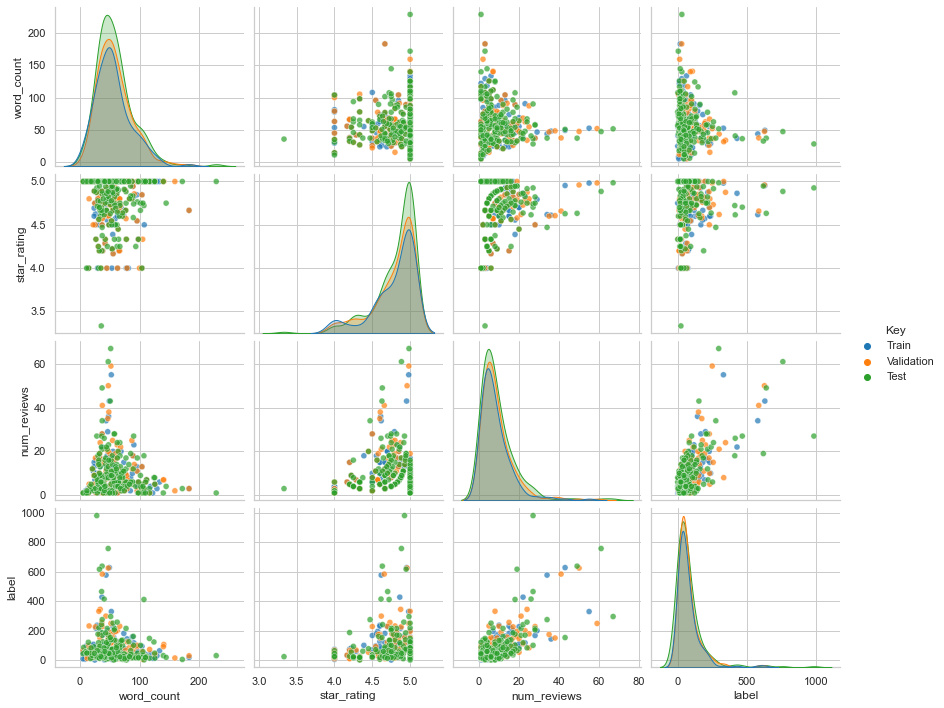

In [14]:
data, scalers = puzzles.load_data()
x_train, y_train = data['train']
x_val, y_val = data['validation']

puzzles.plot_data(**data)

Some randomly generated samples are added to the initial dataset to cover a larger portion of the sampling space, otherwise the attribute `num_reviews` is forced to be monotonic just for the portion of the space covered by the ground samples with respect to the other to attributes. Moreover, more samples are generated for this specific attribute being both the most important and the most difficult to constraint.

* word_count: decreasing (longer reviews are less effective)
* star_rating: increasing (higher ratings lead to higher sales)
* num_reviews: increasing (higher number of reviews are more effective)

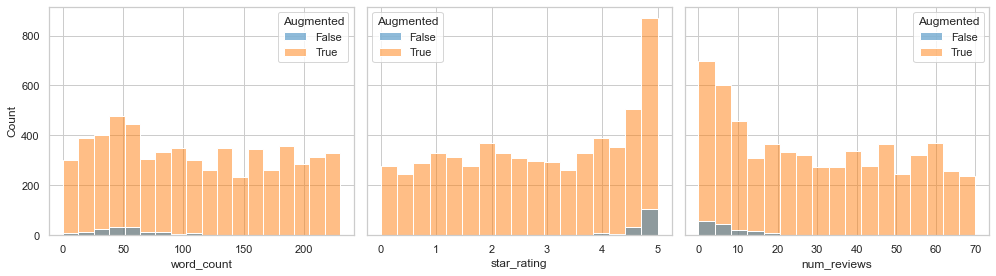

In [15]:
(x_aug, y_aug), aug_scalers = puzzles.get_augmented_data(
    x_train, y_train, num_random=3 * len(x_train), num_augmented=[3, 4, 8]
)
puzzles.plot_augmented(x_aug, y_aug)

## MLP

47.33 (avg. violation), 0.4189 (pct. violation)
0.691 (train r2), 0.5568 (validation r2), 0.5174 (test r2)


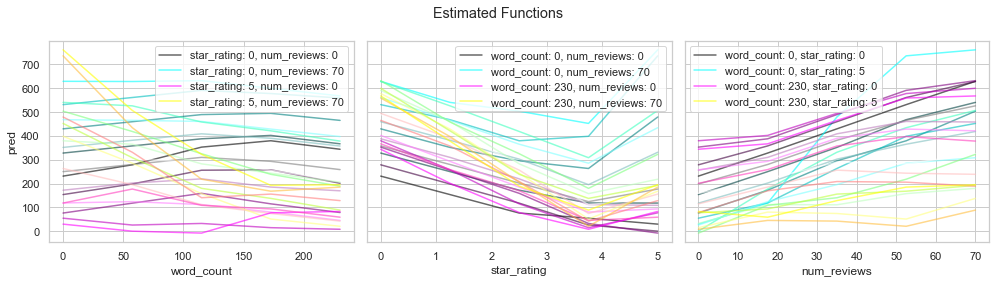

In [16]:
mlp = MLP(output_act=OUTPUT_ACT, h_units=H_UNITS, scalers=scalers)
mlp.compile(optimizer=OPTIMIZER, loss=LOSS)

mlp.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=get_callbacks(), verbose=0)
puzzles.evaluation_summary(mlp, **data)

## SBR

In [17]:
sbr_batches = SBRBatchGenerator(x_aug, y_aug['label'], y_aug['ground_index'], y_aug['monotonicity'], 4)
sbr_batches.batches[0].head(16)

,word_count,star_rating,num_reviews,label,monotonicity
0,88.245834,1.701619,47.018562,NaN,0.0
1,51.346584,1.701619,47.018562,NaN,1.0
2,122.801895,1.701619,47.018562,NaN,-1.0
3,137.121567,1.701619,47.018562,NaN,-1.0
4,88.245834,1.047880,47.018562,NaN,-1.0
5,88.245834,3.660735,47.018562,NaN,1.0
6,88.245834,2.711626,47.018562,NaN,1.0
7,88.245834,1.701619,45.971958,NaN,-1.0
8,88.245834,1.701619,31.714811,NaN,-1.0
9,88.245834,1.701619,30.708107,NaN,-1.0


0.5182 (avg. violation), 0.02647 (pct. violation)
0.639 (train r2), 0.5965 (validation r2), 0.4443 (test r2)


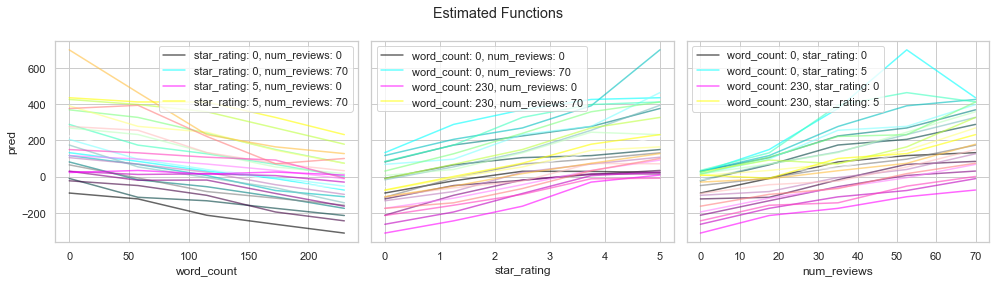

In [18]:
sbr_none = SBR(output_act=OUTPUT_ACT, h_units=H_UNITS, scalers=aug_scalers)
sbr_none.compile(optimizer=OPTIMIZER, loss=LOSS)

sbr_none.fit(sbr_batches, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=get_callbacks(), verbose=0)
puzzles.evaluation_summary(sbr_none, **data)

## SBR Tanh

5.375 (avg. violation), 0.2746 (pct. violation)
0.6319 (train r2), 0.5639 (validation r2), 0.4586 (test r2)


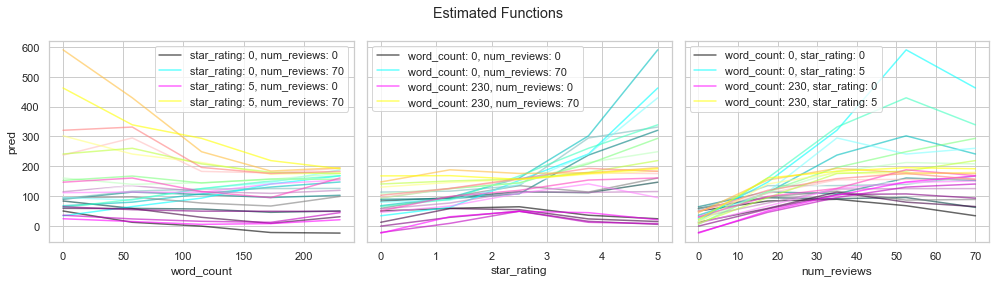

In [19]:
sbr_tanh = SBR(output_act=OUTPUT_ACT, h_units=H_UNITS, regularizer_act=hard_tanh, scalers=aug_scalers)
sbr_tanh.compile(optimizer=OPTIMIZER, loss=LOSS)

sbr_tanh.fit(sbr_batches, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=get_callbacks(), verbose=0)
puzzles.evaluation_summary(sbr_tanh, **data)
